## float, range (important features)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('important_range_LCE_230302.csv')

In [45]:
#import missingno as msno
#msno.bar(df)

In [4]:
#df = df.dropna(axis=1, thresh=1)

## Preprocessing
### 1.annotation result = 3, Null drop & binarization

In [6]:
null_annot = list(np.where(df['annotation_result'].isna() == True)[0])
df = df.drop(null_annot, axis = 'index')
df.index = range(len(df))

three_annot = list(np.where(df['annotation_result'] == 3)[0])
df = df.drop(three_annot, axis = 'index')
df.index = range(len(df))

df['annotation_result'].unique()

zero = list(np.where(df['annotation_result'] == 0)[0])
one = list(np.where(df['annotation_result'] == 1)[0])
two = list(np.where(df['annotation_result'] == 2)[0])
df['annotation_result'][zero] = 0
df['annotation_result'][one] = 0
df['annotation_result'][two] = 1

df['annotation_result'].unique()

array([0., 1.])

### 결측치 mode(), data split

In [43]:
#df = df.fillna(df.mean())

#
df = df.fillna(df.mode().iloc[0])
#df

# 
#df = df.fillna(df.median().iloc[0])
#df

In [44]:
X = df.iloc[:,:60]
y = np.ravel(df.loc[:, ['annotation_result']])

### one-hot encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(X)
X_encoded

<1784x8887 sparse matrix of type '<class 'numpy.float64'>'
	with 107040 stored elements in Compressed Sparse Row format>

### Scaler 

In [18]:
# 1. Standard Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, scale

# Initialize the StandardScaler
#standard_scaler = StandardScaler()
# Fit the scaler on the training data
#standard_scaler.fit(X_train)
# Scale the training, validation, and test data using the scaler
#X_train_standard = standard_scaler.transform(X_train)
#X_val_standard = standard_scaler.transform(X_val)
#X_test_standard = standard_scaler.transform(X_test)



# 2. Initialize the RobustScaler
robust_scaler = RobustScaler()
# Scale the training, validation, and test data using the scaler
#X_train = robust_scaler.fit_transform(X_train)
#X_test = robust_scaler.transform(X_test)
X_scaled = robust_scaler.fit_transform(X_encoded.toarray())

### Train/Test Split 

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("Training set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Training set:  (1427, 8887) (1427,)
Test set:  (357, 8887) (357,)


### med, float + range

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       271
         1.0       0.63      0.38      0.48        86

    accuracy                           0.80       357
   macro avg       0.73      0.66      0.68       357
weighted avg       0.78      0.80      0.78       357



Text(0.5, 1.0, 'Med range')

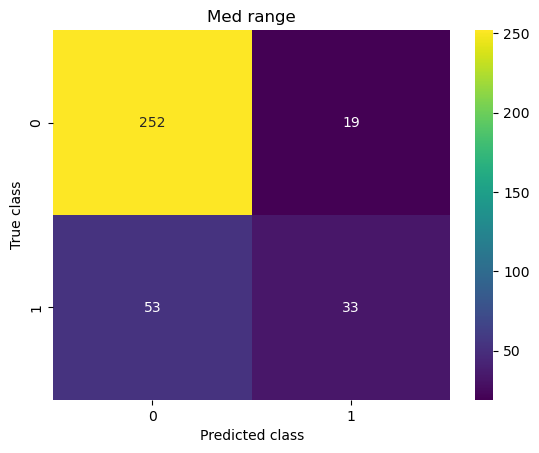

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns

model_original = XGBClassifier(random_state = 42)
model_original.fit(X_train, y_train)
y_pred = model_original.predict(X_test)

print(classification_report(y_test, y_pred))
      
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap='viridis')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med range")  

### med, float + range + tuning

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       271
         1.0       0.61      0.47      0.53        86

    accuracy                           0.80       357
   macro avg       0.72      0.68      0.70       357
weighted avg       0.79      0.80      0.79       357



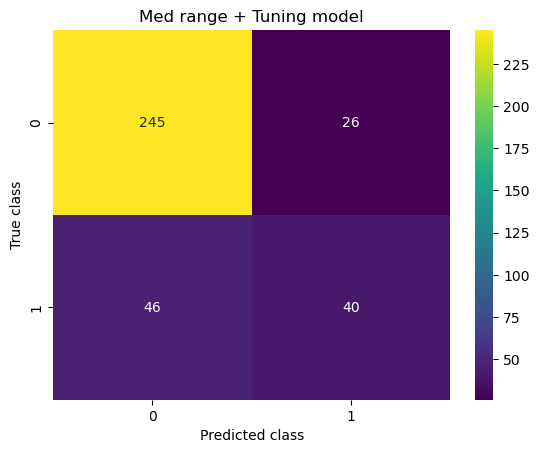

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {'n_estimators': [20, 50, 100, 200],
          'max_depth': [2, 3, 4, 5],
          'learning_rate': [0.01, 0.1, 0.2, 0.5]}

grid_search = GridSearchCV(estimator=model_original, param_grid=param_grid, scoring ='f1', cv=5)
grid_search.fit(X_encoded, y)

best_model = XGBClassifier(**grid_search.best_params_, random_state =42)
print("Best parameters found: ", grid_search.best_params_)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med range + Tuning")
plt.show()

### med, range + weights 

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       271
         1.0       0.54      0.51      0.53        86

    accuracy                           0.78       357
   macro avg       0.70      0.69      0.69       357
weighted avg       0.77      0.78      0.78       357



Text(0.5, 1.0, 'Med range + weights')

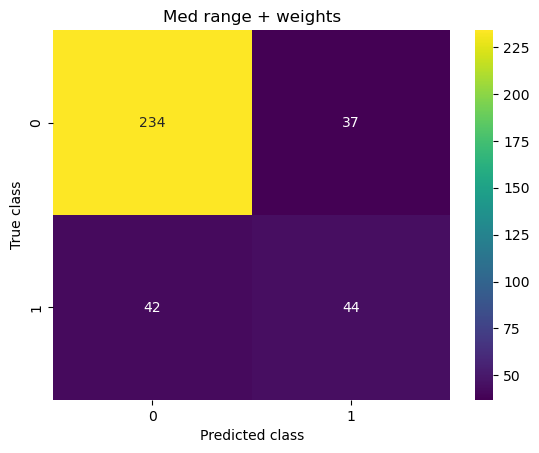

In [34]:
pos_ratio = sum(y_train == 0) / sum(y_train == 1)

model_weights = XGBClassifier(
    scale_pos_weight = pos_ratio,
    random_state =42
)

model_weights.fit(X_train, y_train)

y_pred_weight = model_weights.predict(X_test)

print(classification_report(y_test, y_pred_weight))

cm = confusion_matrix(y_test, y_pred_weight)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med range + weights")

### med, range + weights + tuning 

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       271
         1.0       0.61      0.49      0.54        86

    accuracy                           0.80       357
   macro avg       0.73      0.69      0.71       357
weighted avg       0.79      0.80      0.79       357



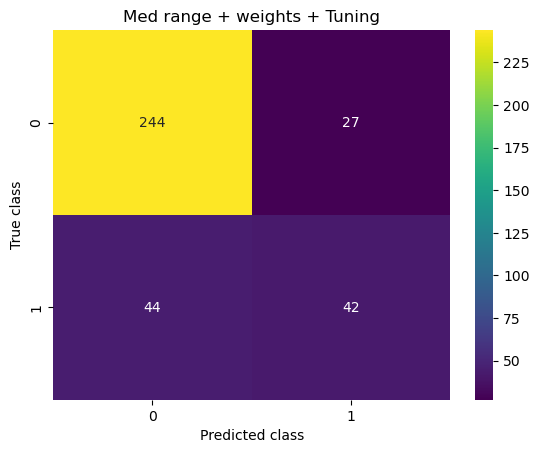

In [35]:
grid_search_wt = GridSearchCV(estimator=model_weights, param_grid=param_grid, scoring ='f1', cv=5)
grid_search_wt.fit(X_encoded, y)

best_model_wt = XGBClassifier(**grid_search_wt.best_params_, random_state =42)
print("Best parameters found: ", grid_search.best_params_)

best_model_wt.fit(X_train, y_train)

y_pred_wt = best_model_wt.predict(X_test)
print(classification_report(y_test, y_pred_wt))

cm = confusion_matrix(y_test, y_pred_wt)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med range + weights + Tuning")
plt.show()

### AUROC

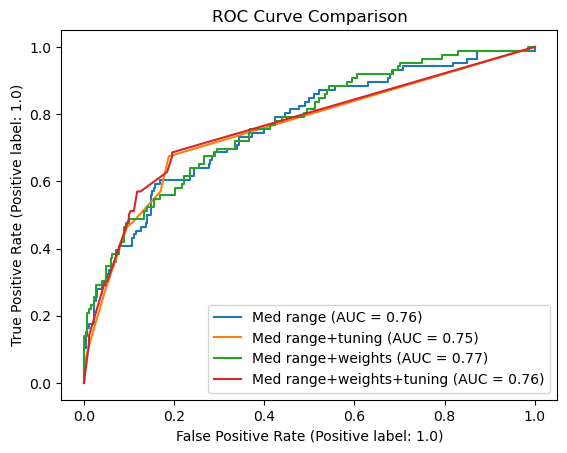

Original's AUC:  0.7646957864927486
Original + Tuning's AUC:  0.7549987127778254
Weights's AUC:  0.7721616751051232
Weights + Tuning's AUC:  0.7634943791298378

best model: Med range+weights
best score:  0.7721616751051232


In [40]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(model_original, X_test, y_test, name= 'Med range', ax=ax)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name= 'Med range+tuning', ax=ax)

RocCurveDisplay.from_estimator(model_weights, X_test, y_test, name= 'Med range+weights', ax=ax)
RocCurveDisplay.from_estimator(best_model_wt, X_test, y_test, name= 'Med range+weights+tuning', ax=ax)

ax.set_title('ROC Curve Comparison')
ax.legend()
plt.show()

y_pred_proba1 = model_original.predict_proba(X_test)[:, 1]
auc1 = roc_auc_score(y_test, y_pred_proba1)
print("Original's AUC: ", auc1)
y_pred_proba2 = best_model.predict_proba(X_test)[:, 1]
auc2 = roc_auc_score(y_test, y_pred_proba2)
print("Original + Tuning's AUC: ", auc2)

y_pred_proba3 = model_weights.predict_proba(X_test)[:, 1]
auc3 = roc_auc_score(y_test, y_pred_proba3)
print("Weights's AUC: ", auc3)
y_pred_proba4 = best_model_wt.predict_proba(X_test)[:, 1]
auc4 = roc_auc_score(y_test, y_pred_proba4)
print("Weights + Tuning's AUC: ", auc4)

#### 
print("")
max_score = max(auc1, auc2, auc3, auc4)

if max_score == auc1:
    print("best model: Med range")
elif max_score == auc2:
    print("best model: Med range+tuning")
elif max_score == auc3:
    print("best model: Med range+weights")
else:
    print("best model: Med range+weights+tuning")



print("best score: ", max_score )